In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import glob

import sys
sys.path.append("../..") # include base dir

from jlonevae_lib.architecture.load_model import load_model
import jlonevae_lib.architecture.vae_jacobian as vj

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-tr_7q_xr because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
### COPYPASTA from disentanglement_lib/disentanglement_lib/data/ground_truth/threeDots.py
### EASIER than trying to figure out how to import that file here

# create an image with dots of the given radius (range 0 to 1)
# placed at the given locations (shape: (N, 2)) in the range 0 to 1
# the output image is shape (64, 64, 1)
# with a black dot on a white background
# and some gray colors on the border pixels
# (the gray color is created by making a purely black circle on a 10x larger image
# and then resizing the image smaller and averaging nearby pixels
def draw_dots_to_image_array(radius, dot_centers):
    num_object = dot_centers.shape[0]
    im_side_len = 64
    # in order to get nicely averaged/grayscale shape boundary
    # we draw on a larger canvas and scale down
    # Create a black image
    upscale_image_factor = 10
    precision_scale = 10
    black = 0 
    up_img = np.ones((im_side_len * upscale_image_factor,im_side_len *
      upscale_image_factor,1))
    up_radius = int(im_side_len * radius * upscale_image_factor * 2**precision_scale)
    for i in range(num_object):
        up_center = np.floor(im_side_len * dot_centers[i] * upscale_image_factor * 2**precision_scale).astype(int)
        # negative thickness means filled circle
        circle = cv2.circle(up_img, tuple(up_center), up_radius, color=black, thickness = -1, shift=precision_scale)
    arr = cv2.resize(up_img, (im_side_len,im_side_len), interpolation=cv2.INTER_AREA)
    return arr

# Embed into model

In [4]:
combinedOutputs = "trainedModels"

In [17]:
pwd()

'/mnt/homes/@LH-CORNELL.EDU/61/tsr42-1000002/jlonevae/scratchwork/TinyICAData'

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"


In [59]:
x1, x2, x3 = torch.meshgrid(torch.tensor(np.linspace(-2,2,11),dtype=torch.float32),
              torch.tensor(np.linspace(-2,2,11),dtype=torch.float32),
              torch.tensor(np.linspace(-2,2,11),dtype=torch.float32))
test_data = torch.vstack((x1.flatten(),x2.flatten(),x3.flatten())).T.to("cuda")

./toyDatasetTrainedModels/20210628-160634/twoone_beta0_001_gamma0_000_embgamma0_000/cache_batch_no100000


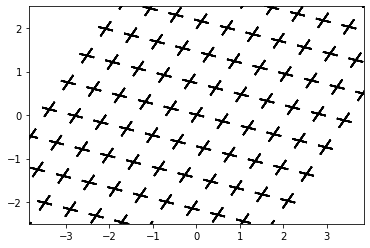

./toyDatasetTrainedModels/20210629-005355/twoone_beta0_005_gamma0_000_embgamma0_000/cache_batch_no100000


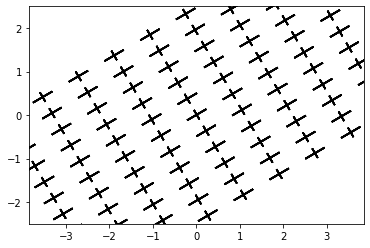

./toyDatasetTrainedModels/20210629-094258/twoone_beta0_010_gamma0_000_embgamma0_000/cache_batch_no100000


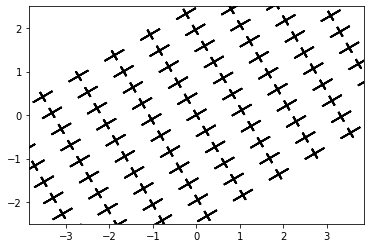

In [64]:
for gamma in ["0_001","0_005","0_010"]:
    search_string = f"./toyDatasetTrainedModels/*/twoone_beta{gamma}_gamma0_000_embgamma0_000/cache_batch_no100000"
    model_path_matches = glob.glob(search_string)
    for model_path in np.sort(model_path_matches):
        print(model_path)
        model = load_model(model_path,device)
        decs = model.decode(test_data)
        jacs = vj.compute_generator_jacobian_optimized(model, test_data,device="cuda")
        for name, p in model.named_parameters():
            if name == "gen_fcs.0.weight":
                w = p.data.cpu().detach().numpy()
        #print(-np.sort(-np.diag(w.T@w)))
        ll = 0.1
        for ix, dec in enumerate(decs):
            for v in jacs[:,ix]:
                plt.plot((dec[0]-v[0]*ll,dec[0]+v[0]*ll),(dec[1]-v[1]*ll,dec[1]+v[1]*ll), color="black")
        plt.axis("equal")
        plt.ylim((-2.5,2.5))
        plt.xlim((-2.5,2.5))
        plt.show();plt.close();

In [74]:
sscale = 0.5
x1, x2, x3 = torch.meshgrid(torch.tensor(np.linspace(-sscale,sscale,11),dtype=torch.float32),
              torch.tensor(np.linspace(-sscale,sscale,11),dtype=torch.float32),
              torch.tensor(np.linspace(-sscale,sscale,11),dtype=torch.float32))
test_data = torch.vstack((x1.flatten(),x2.flatten(),x3.flatten())).T.to("cuda")

./toyDatasetTrainedModels/20210630-163204/big_twoone_beta0_001_gamma0_000_embgamma0_100/cache_batch_no100000


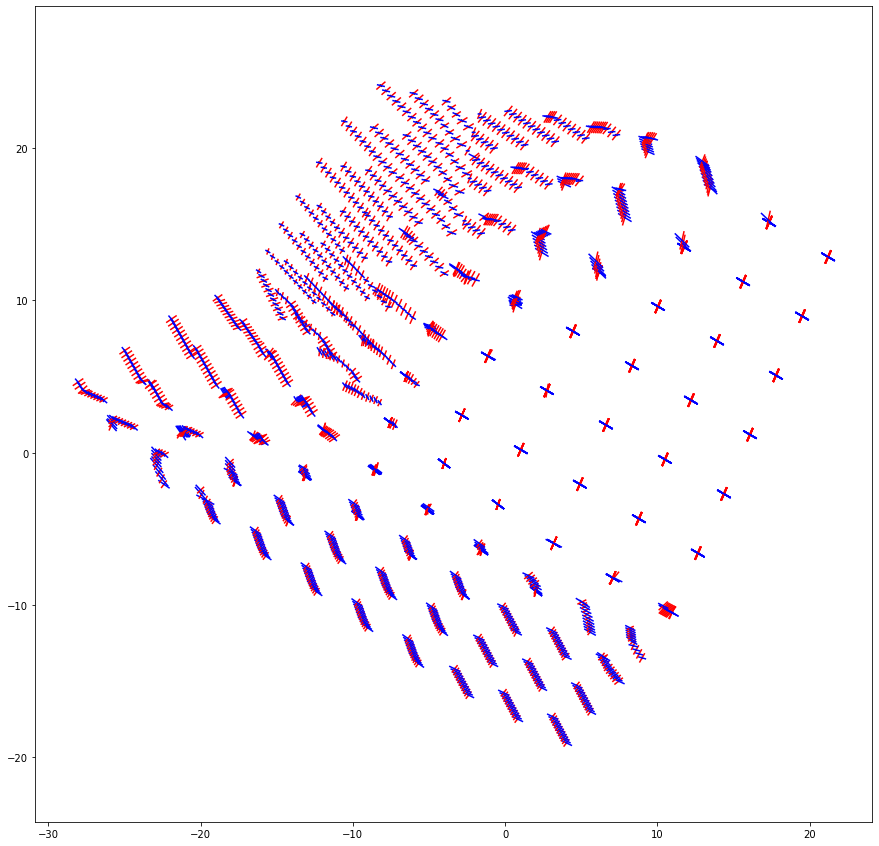

./toyDatasetTrainedModels/20210630-180015/big_twoone_beta0_001_gamma0_000_embgamma1_000/cache_batch_no100000


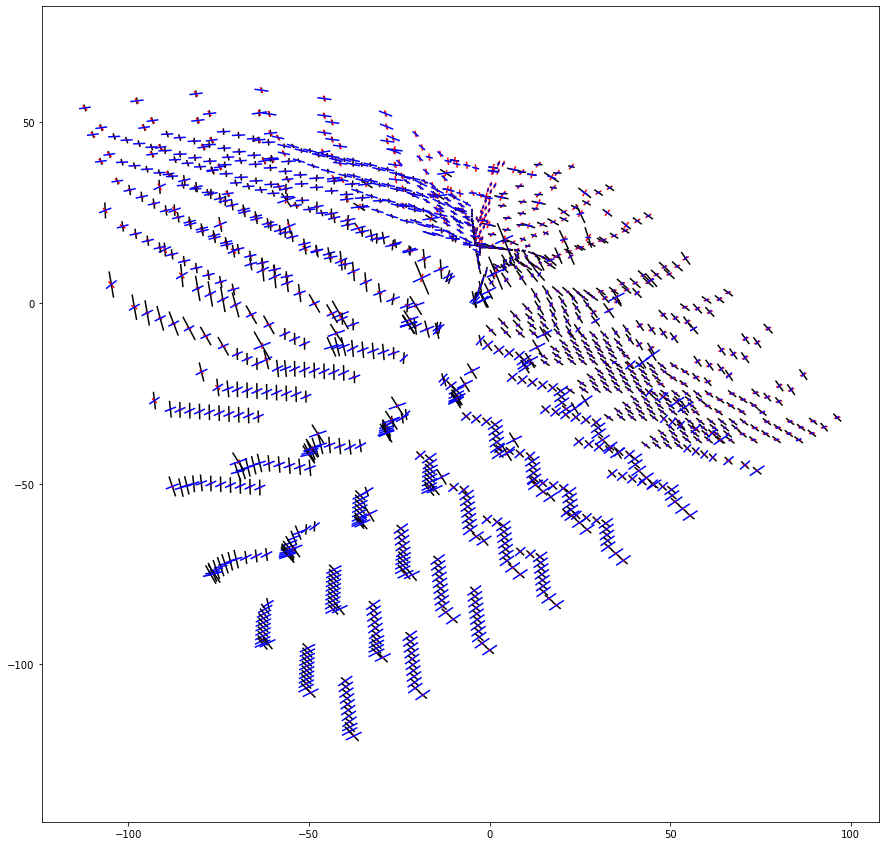

In [83]:
#big_lone_beta0_001_gamma0_000_embgamma10_000
for embgamma in ["0_100","1_000"]:
    plt.figure(figsize=(15,15))
    search_string = f"./toyDatasetTrainedModels/*/big_twoone_beta0_001_gamma0_000_embgamma{embgamma}/cache_batch_no100000"
    model_path_matches = glob.glob(search_string)
    for model_path in np.sort(model_path_matches):
        print(model_path)
        model = load_model(model_path,device)
        decs = model.decode(test_data)
        jacs = vj.compute_generator_jacobian_optimized(model, test_data,device="cuda")
        for name, p in model.named_parameters():
            if name == "gen_fcs.0.weight":
                w = p.data.cpu().detach().numpy()
        #print(-np.sort(-np.diag(w.T@w)))
        ll = 0.01
        for ix, dec in enumerate(decs):
            v = jacs[0,ix]
            plt.plot((dec[0]-v[0]*ll,dec[0]+v[0]*ll),(dec[1]-v[1]*ll,dec[1]+v[1]*ll), color="black")
            v = jacs[1,ix]
            plt.plot((dec[0]-v[0]*ll,dec[0]+v[0]*ll),(dec[1]-v[1]*ll,dec[1]+v[1]*ll), color="red")
            v = jacs[2,ix]
            plt.plot((dec[0]-v[0]*ll,dec[0]+v[0]*ll),(dec[1]-v[1]*ll,dec[1]+v[1]*ll), color="blue")
        plt.axis("equal")
        #plt.ylim((-2.5,2.5))
        #plt.xlim((-2.5,2.5))
        plt.show();plt.close();

./toyDatasetTrainedModels/20210628-160634/twoone_beta0_001_gamma0_000_embgamma0_000/cache_batch_no100000


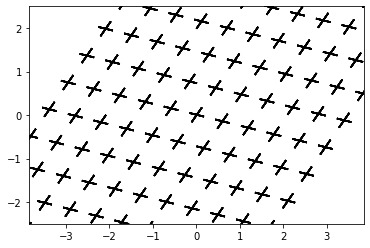

./toyDatasetTrainedModels/20210629-005355/twoone_beta0_005_gamma0_000_embgamma0_000/cache_batch_no100000


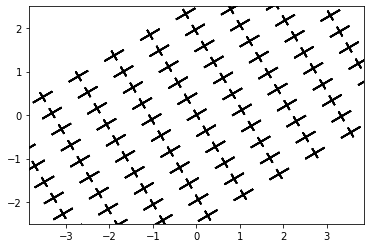

./toyDatasetTrainedModels/20210629-094258/twoone_beta0_010_gamma0_000_embgamma0_000/cache_batch_no100000


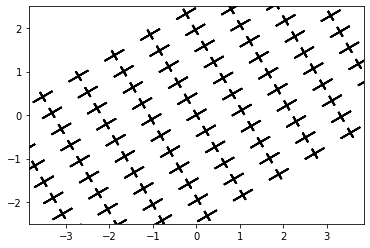

In [65]:
for gamma in ["0_001","0_005","0_010"]:
    search_string = f"./toyDatasetTrainedModels/*/twoone_beta{gamma}_gamma0_000_embgamma0_000/cache_batch_no100000"
    model_path_matches = glob.glob(search_string)
    for model_path in np.sort(model_path_matches):
        print(model_path)
        model = load_model(model_path,device)
        decs = model.decode(test_data)
        for name, p in model.named_parameters():
            if name == "gen_fcs.0.weight":
                w = p.data.cpu().detach().numpy()
        #print(-np.sort(-np.diag(w.T@w)))
        ll = 0.1
        for dec in decs:
            for v in w.T:
                plt.plot((dec[0]-v[0]*ll,dec[0]+v[0]*ll),(dec[1]-v[1]*ll,dec[1]+v[1]*ll), color="black")
        plt.axis("equal")
        plt.ylim((-2.5,2.5))
        plt.xlim((-2.5,2.5))
        plt.show();plt.close();

./toyDatasetTrainedModels/20210624-160415/proper_beta0_001_gamma0_000_embgamma0_000/cache_batch_no100000


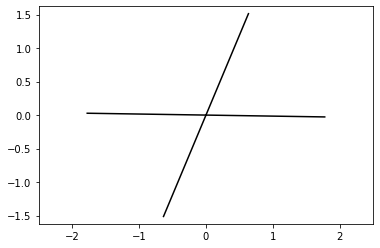

./toyDatasetTrainedModels/20210624-202419/proper_beta0_001_gamma0_001_embgamma0_000/cache_batch_no100000


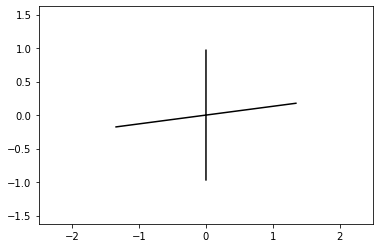

./toyDatasetTrainedModels/20210624-223602/proper_beta0_001_gamma0_005_embgamma0_000/cache_batch_no100000


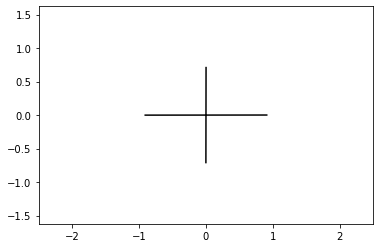

./toyDatasetTrainedModels/20210624-181306/proper_beta0_001_gamma0_010_embgamma0_000/cache_batch_no100000


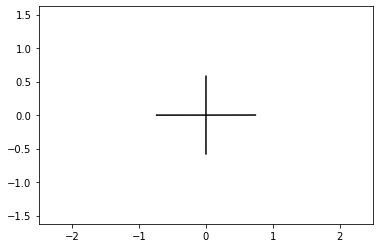

In [8]:
for gamma in ["0_000","0_001","0_005","0_010"]:
    model_path_matches = glob.glob(f"./toyDatasetTrainedModels/*/proper_beta0_001_gamma{gamma}_embgamma0_000/cache_batch_no100000")
    for model_path in np.sort(model_path_matches):
        print(model_path)
        model = load_model(model_path,device)
        for name, p in model.named_parameters():
            if name == "gen_fcs.0.weight":
                w = p.data.cpu().detach().numpy()
        #print(-np.sort(-np.diag(w.T@w)))
        for v in w.T:
            plt.plot((-v[0],v[0]),(-v[1],v[1]), color="black")
        plt.axis("equal")
        plt.ylim((-2.5,2.5))
        plt.xlim((-2.5,2.5))
        plt.show();plt.close();

./toyDatasetTrainedModels/20210628-160634/twoone_beta0_001_gamma0_000_embgamma0_000/cache_batch_no100000


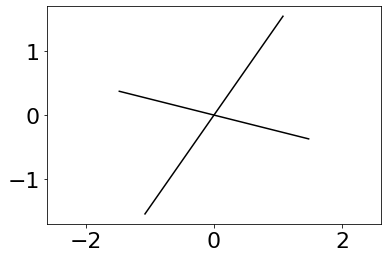

./toyDatasetTrainedModels/20210629-005355/twoone_beta0_005_gamma0_000_embgamma0_000/cache_batch_no100000


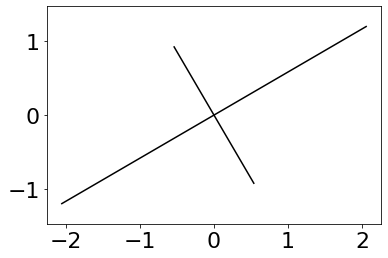

./toyDatasetTrainedModels/20210629-094258/twoone_beta0_010_gamma0_000_embgamma0_000/cache_batch_no100000


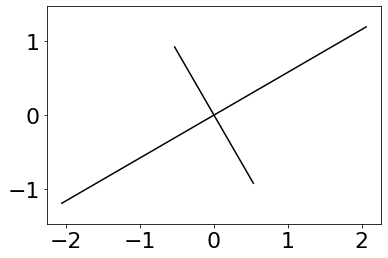

./toyDatasetTrainedModels/20210628-144447/twoone_beta0_001_gamma0_000_embgamma0_001/cache_batch_no100000


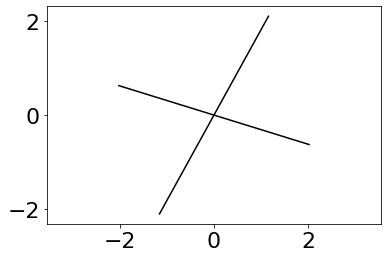

./toyDatasetTrainedModels/20210628-233048/twoone_beta0_005_gamma0_000_embgamma0_001/cache_batch_no100000


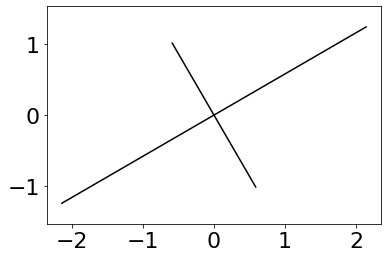

./toyDatasetTrainedModels/20210629-082034/twoone_beta0_010_gamma0_000_embgamma0_001/cache_batch_no100000


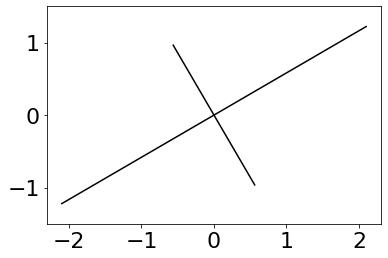

./toyDatasetTrainedModels/20210628-152532/twoone_beta0_001_gamma0_000_embgamma0_005/cache_batch_no100000
./toyDatasetTrainedModels/20210629-001154/twoone_beta0_005_gamma0_000_embgamma0_005/cache_batch_no100000
./toyDatasetTrainedModels/20210629-090137/twoone_beta0_010_gamma0_000_embgamma0_005/cache_batch_no100000


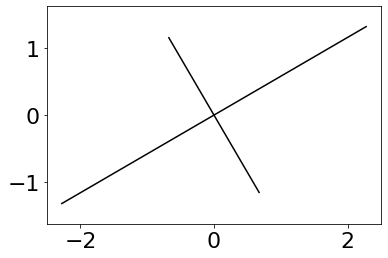

./toyDatasetTrainedModels/20210628-140354/twoone_beta0_001_gamma0_000_embgamma0_010/cache_batch_no100000


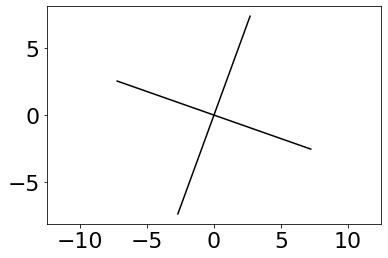

./toyDatasetTrainedModels/20210628-224955/twoone_beta0_005_gamma0_000_embgamma0_010/cache_batch_no100000


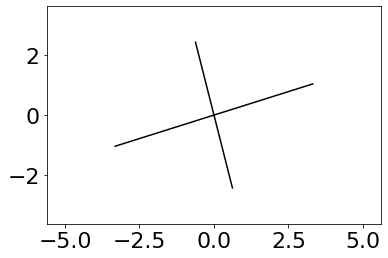

./toyDatasetTrainedModels/20210629-073944/twoone_beta0_010_gamma0_000_embgamma0_010/cache_batch_no100000
./toyDatasetTrainedModels/20210629-143528/twoone_beta0_001_gamma0_000_embgamma0_100/cache_batch_no100000
./toyDatasetTrainedModels/20210629-151627/twoone_beta0_001_gamma0_000_embgamma1_000/cache_batch_no100000


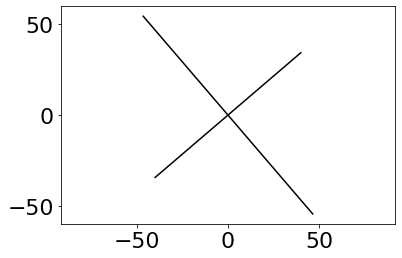

./toyDatasetTrainedModels/20210629-155753/twoone_beta0_001_gamma0_000_embgamma10_000/cache_batch_no100000


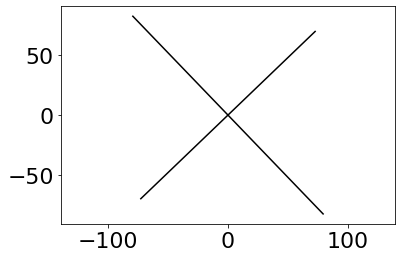

In [22]:
for embgamma in ["0_000","0_001","0_005","0_010","0_100","1_000","10_000"]:
    model_path_matches = glob.glob(f"./toyDatasetTrainedModels/*/twoone_beta*_gamma0_000_embgamma{embgamma}/cache_batch_no100000")
    for model_path in np.sort(model_path_matches):
        print(model_path)
        model = load_model(model_path,device)
        for name, p in model.named_parameters():
            if name == "gen_fcs.0.weight":
                w = p.data.cpu().detach().numpy()
        #print(-np.sort(-np.diag(w.T@w)))
        for v in w.T:
            plt.plot((-v[0],v[0]),(-v[1],v[1]), color="black")
        plt.axis("equal")
        lim = np.max(np.abs(w))*1.1
        if not lim > 0:
            continue
        plt.ylim((-lim,lim))
        plt.xlim((-lim,lim))
        plt.show();plt.close();

./toyDatasetTrainedModels/20210624-160415/proper_beta0_001_gamma0_000_embgamma0_000/cache_batch_no100000


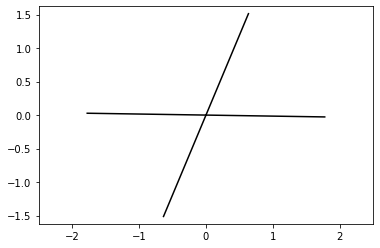

./toyDatasetTrainedModels/20210624-161015/proper_beta0_001_gamma0_000_embgamma0_010/cache_batch_no100000


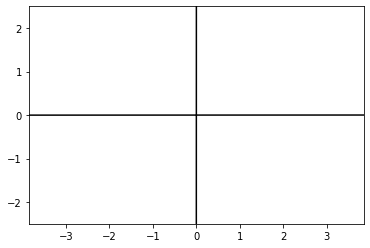

./toyDatasetTrainedModels/20210624-165049/proper_beta0_001_gamma0_000_embgamma0_001/cache_batch_no100000


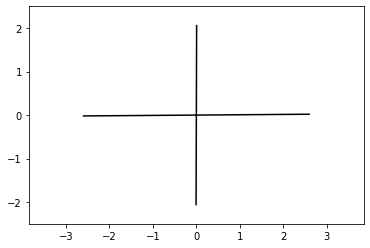

./toyDatasetTrainedModels/20210624-173150/proper_beta0_001_gamma0_000_embgamma0_005/cache_batch_no100000


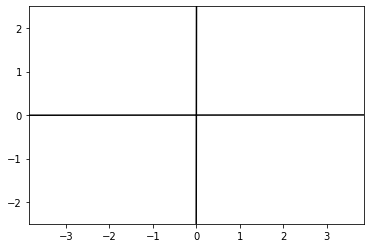

./toyDatasetTrainedModels/20210624-181306/proper_beta0_001_gamma0_010_embgamma0_000/cache_batch_no100000


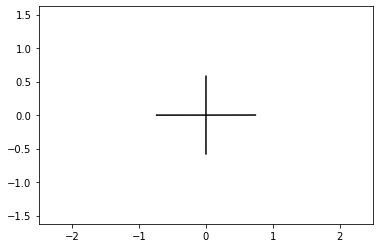

./toyDatasetTrainedModels/20210624-182017/proper_beta0_001_gamma0_010_embgamma0_010/cache_batch_no100000


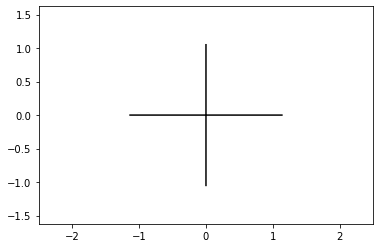

./toyDatasetTrainedModels/20210624-190151/proper_beta0_001_gamma0_010_embgamma0_001/cache_batch_no100000


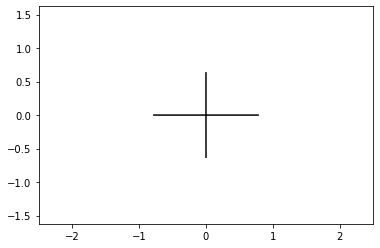

./toyDatasetTrainedModels/20210624-194259/proper_beta0_001_gamma0_010_embgamma0_005/cache_batch_no100000


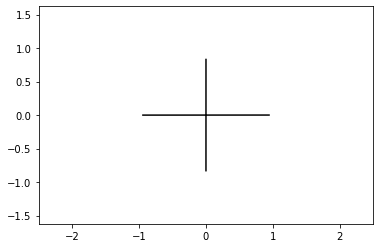

./toyDatasetTrainedModels/20210624-202419/proper_beta0_001_gamma0_001_embgamma0_000/cache_batch_no100000


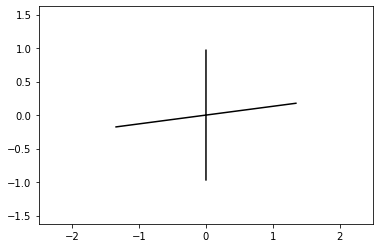

./toyDatasetTrainedModels/20210624-203126/proper_beta0_001_gamma0_001_embgamma0_010/cache_batch_no100000


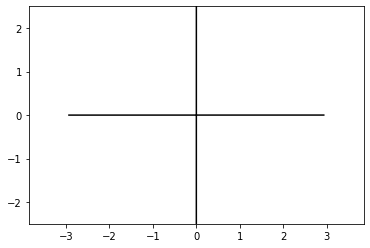

./toyDatasetTrainedModels/20210624-211305/proper_beta0_001_gamma0_001_embgamma0_001/cache_batch_no100000


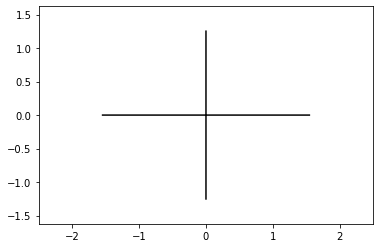

./toyDatasetTrainedModels/20210624-215439/proper_beta0_001_gamma0_001_embgamma0_005/cache_batch_no100000


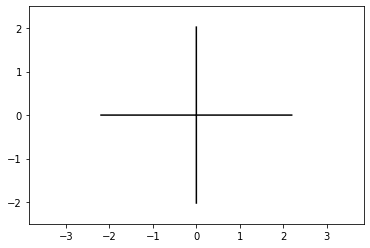

./toyDatasetTrainedModels/20210624-223602/proper_beta0_001_gamma0_005_embgamma0_000/cache_batch_no100000


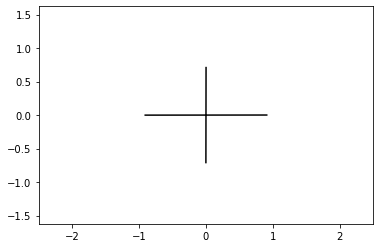

./toyDatasetTrainedModels/20210624-224311/proper_beta0_001_gamma0_005_embgamma0_010/cache_batch_no100000


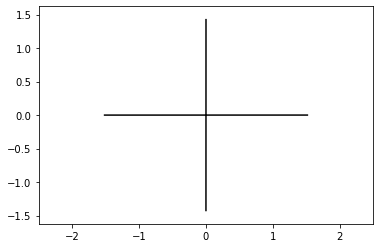

./toyDatasetTrainedModels/20210624-232435/proper_beta0_001_gamma0_005_embgamma0_001/cache_batch_no100000


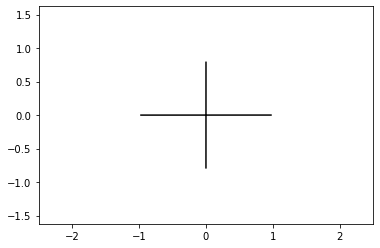

./toyDatasetTrainedModels/20210625-000600/proper_beta0_001_gamma0_005_embgamma0_005/cache_batch_no100000


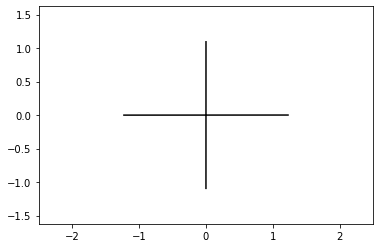

./toyDatasetTrainedModels/20210625-004741/proper_beta0_005_gamma0_000_embgamma0_000/cache_batch_no100000


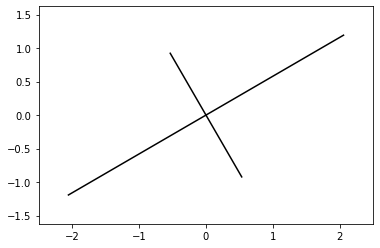

./toyDatasetTrainedModels/20210625-005344/proper_beta0_005_gamma0_000_embgamma0_010/cache_batch_no100000


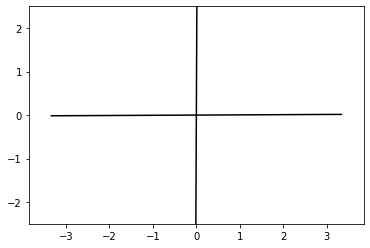

./toyDatasetTrainedModels/20210625-013417/proper_beta0_005_gamma0_000_embgamma0_001/cache_batch_no100000


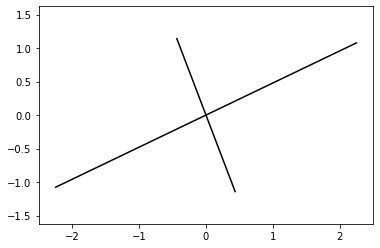

./toyDatasetTrainedModels/20210625-021447/proper_beta0_005_gamma0_000_embgamma0_005/cache_batch_no100000


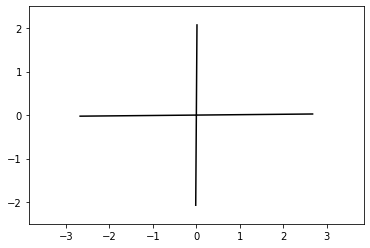

./toyDatasetTrainedModels/20210625-025544/proper_beta0_005_gamma0_010_embgamma0_000/cache_batch_no100000


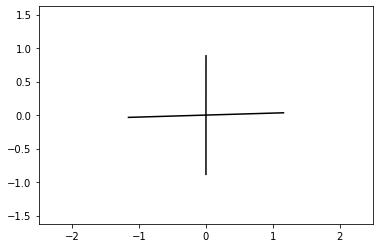

./toyDatasetTrainedModels/20210625-030250/proper_beta0_005_gamma0_010_embgamma0_010/cache_batch_no100000


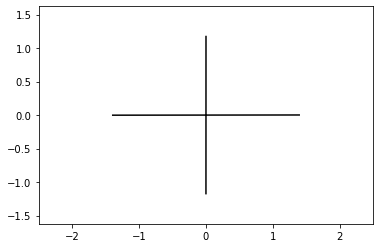

./toyDatasetTrainedModels/20210625-034431/proper_beta0_005_gamma0_010_embgamma0_001/cache_batch_no100000


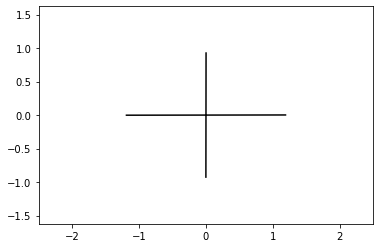

./toyDatasetTrainedModels/20210625-042553/proper_beta0_005_gamma0_010_embgamma0_005/cache_batch_no100000


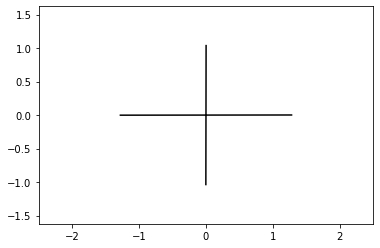

./toyDatasetTrainedModels/20210625-050718/proper_beta0_005_gamma0_001_embgamma0_000/cache_batch_no100000


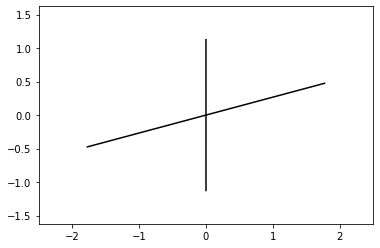

./toyDatasetTrainedModels/20210625-051424/proper_beta0_005_gamma0_001_embgamma0_010/cache_batch_no100000


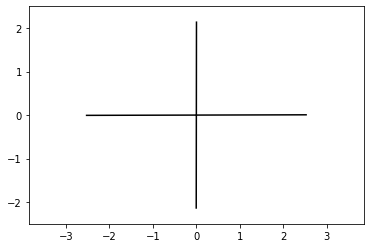

./toyDatasetTrainedModels/20210625-055552/proper_beta0_005_gamma0_001_embgamma0_001/cache_batch_no100000


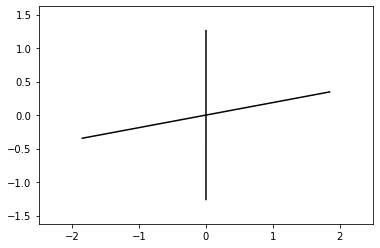

./toyDatasetTrainedModels/20210625-063815/proper_beta0_005_gamma0_001_embgamma0_005/cache_batch_no100000


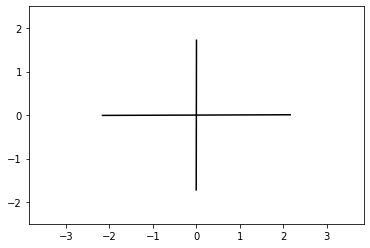

./toyDatasetTrainedModels/20210625-071942/proper_beta0_005_gamma0_005_embgamma0_000/cache_batch_no100000


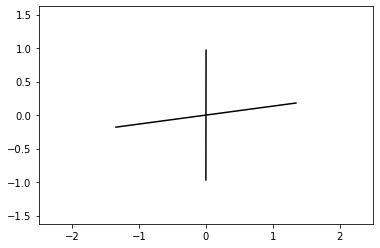

./toyDatasetTrainedModels/20210625-072646/proper_beta0_005_gamma0_005_embgamma0_010/cache_batch_no100000


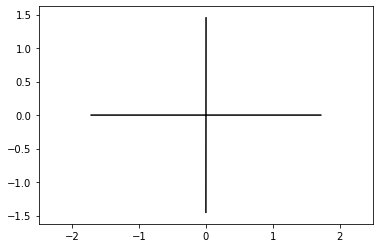

./toyDatasetTrainedModels/20210625-080804/proper_beta0_005_gamma0_005_embgamma0_001/cache_batch_no100000


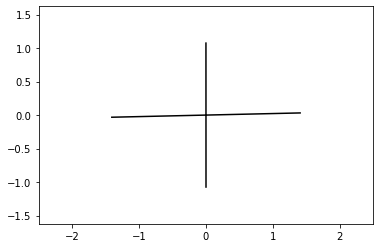

./toyDatasetTrainedModels/20210625-084926/proper_beta0_005_gamma0_005_embgamma0_005/cache_batch_no100000


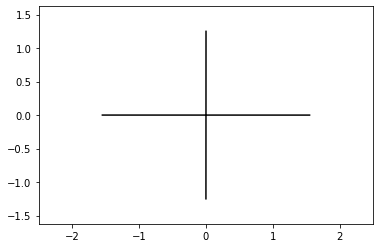

./toyDatasetTrainedModels/20210625-093022/proper_beta0_010_gamma0_000_embgamma0_000/cache_batch_no100000


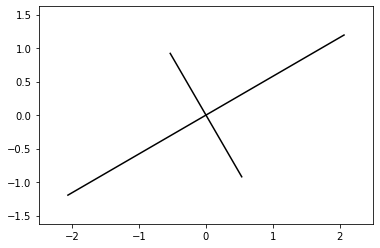

./toyDatasetTrainedModels/20210625-093626/proper_beta0_010_gamma0_000_embgamma0_010/cache_batch_no100000


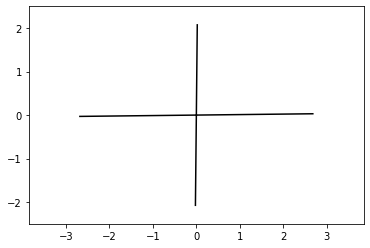

./toyDatasetTrainedModels/20210625-101702/proper_beta0_010_gamma0_000_embgamma0_001/cache_batch_no100000


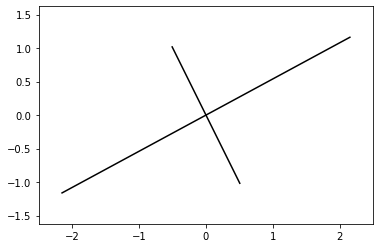

./toyDatasetTrainedModels/20210625-105747/proper_beta0_010_gamma0_000_embgamma0_005/cache_batch_no100000


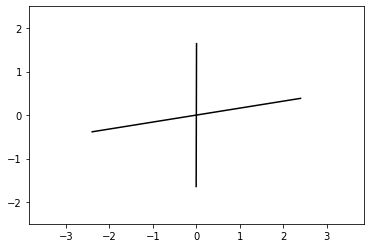

./toyDatasetTrainedModels/20210625-113855/proper_beta0_010_gamma0_010_embgamma0_000/cache_batch_no100000


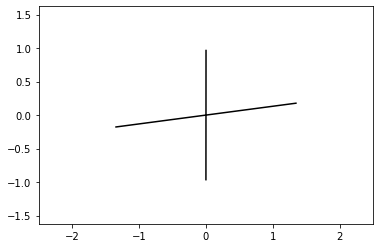

./toyDatasetTrainedModels/20210625-114604/proper_beta0_010_gamma0_010_embgamma0_010/cache_batch_no100000


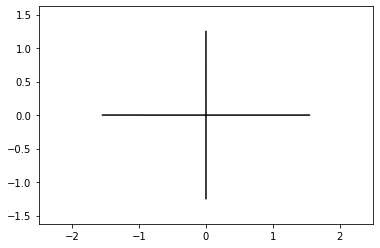

./toyDatasetTrainedModels/20210625-122733/proper_beta0_010_gamma0_010_embgamma0_001/cache_batch_no100000


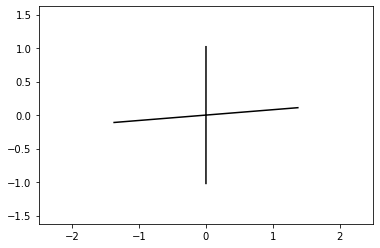

./toyDatasetTrainedModels/20210625-130839/proper_beta0_010_gamma0_010_embgamma0_005/cache_batch_no100000


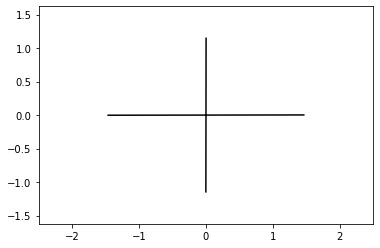

./toyDatasetTrainedModels/20210625-135009/proper_beta0_010_gamma0_001_embgamma0_000/cache_batch_no100000


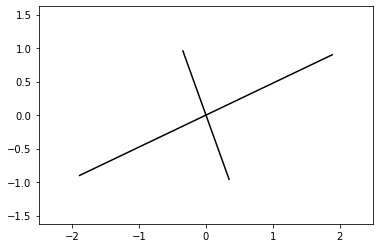

./toyDatasetTrainedModels/20210625-135717/proper_beta0_010_gamma0_001_embgamma0_010/cache_batch_no100000


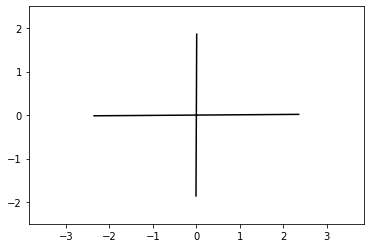

./toyDatasetTrainedModels/20210625-143909/proper_beta0_010_gamma0_001_embgamma0_001/cache_batch_no100000


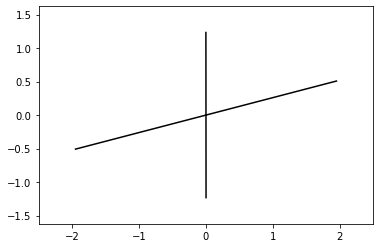

./toyDatasetTrainedModels/20210625-152052/proper_beta0_010_gamma0_001_embgamma0_005/cache_batch_no100000


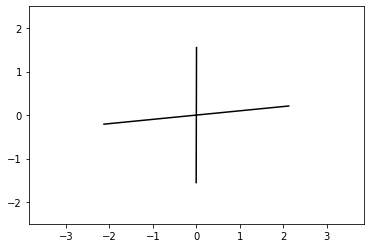

./toyDatasetTrainedModels/20210625-155035/proper_beta0_001_gamma0_000_embgamma-0_001/cache_batch_no100000


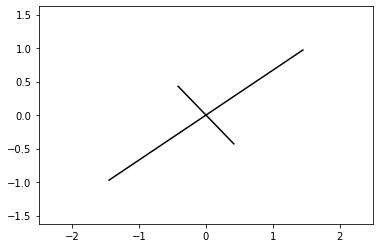

./toyDatasetTrainedModels/20210625-160351/proper_beta0_010_gamma0_005_embgamma0_000/cache_batch_no100000


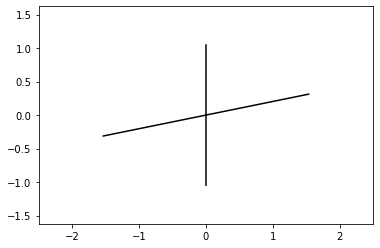

./toyDatasetTrainedModels/20210625-161157/proper_beta0_010_gamma0_005_embgamma0_010/cache_batch_no100000


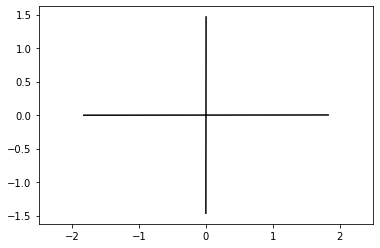

./toyDatasetTrainedModels/20210625-165549/proper_beta0_010_gamma0_005_embgamma0_001/cache_batch_no100000


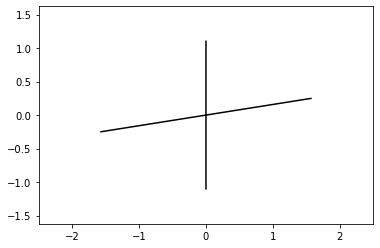

./toyDatasetTrainedModels/20210625-173653/proper_beta0_010_gamma0_005_embgamma0_005/cache_batch_no100000


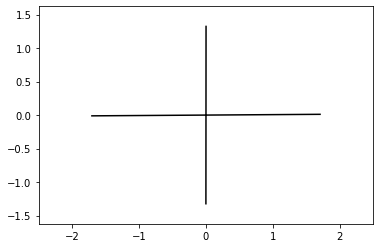

./toyDatasetTrainedModels/20210625-181848/proper_beta0_100_gamma0_000_embgamma0_000/cache_batch_no100000


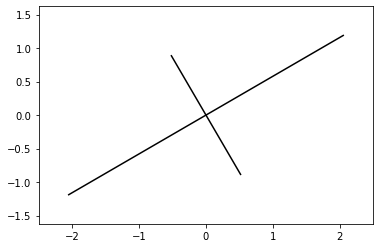

./toyDatasetTrainedModels/20210625-182455/proper_beta0_100_gamma0_000_embgamma0_010/cache_batch_no100000


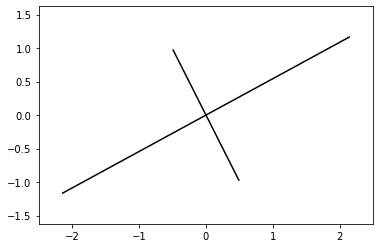

./toyDatasetTrainedModels/20210625-190635/proper_beta0_100_gamma0_000_embgamma0_001/cache_batch_no100000


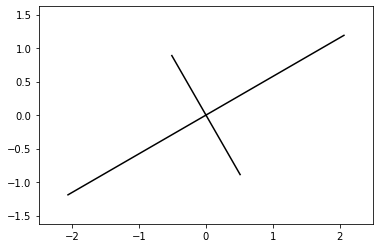

./toyDatasetTrainedModels/20210625-194729/proper_beta0_100_gamma0_000_embgamma0_005/cache_batch_no100000


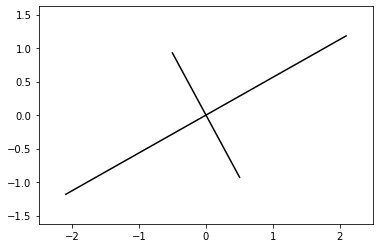

./toyDatasetTrainedModels/20210625-202815/proper_beta0_100_gamma0_010_embgamma0_000/cache_batch_no100000


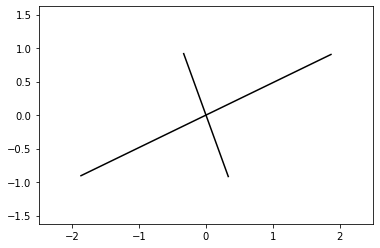

./toyDatasetTrainedModels/20210625-203523/proper_beta0_100_gamma0_010_embgamma0_010/cache_batch_no100000


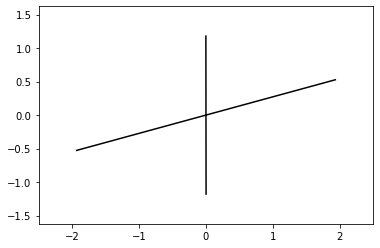

./toyDatasetTrainedModels/20210625-211649/proper_beta0_100_gamma0_010_embgamma0_001/cache_batch_no100000


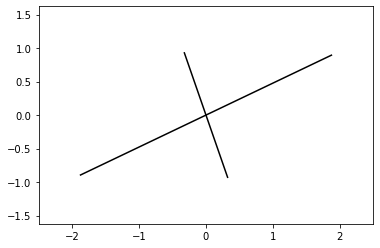

./toyDatasetTrainedModels/20210625-215818/proper_beta0_100_gamma0_010_embgamma0_005/cache_batch_no100000


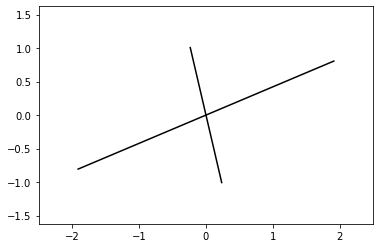

./toyDatasetTrainedModels/20210625-223946/proper_beta0_100_gamma0_001_embgamma0_000/cache_batch_no100000


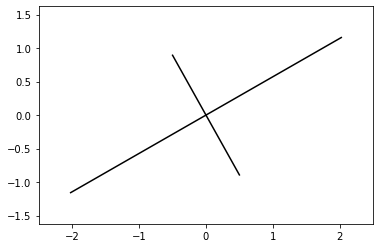

./toyDatasetTrainedModels/20210625-224700/proper_beta0_100_gamma0_001_embgamma0_010/cache_batch_no100000


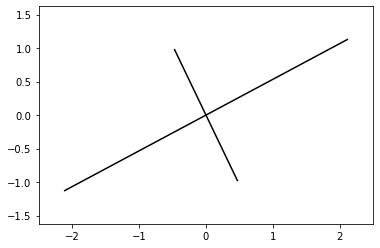

./toyDatasetTrainedModels/20210625-232819/proper_beta0_100_gamma0_001_embgamma0_001/cache_batch_no100000


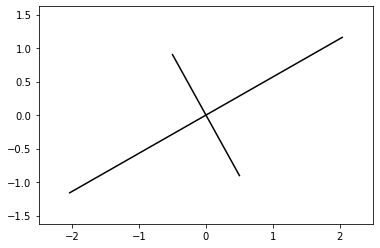

./toyDatasetTrainedModels/20210626-001005/proper_beta0_100_gamma0_001_embgamma0_005/cache_batch_no100000


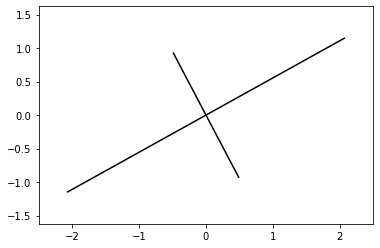

./toyDatasetTrainedModels/20210626-005141/proper_beta0_100_gamma0_005_embgamma0_000/cache_batch_no100000


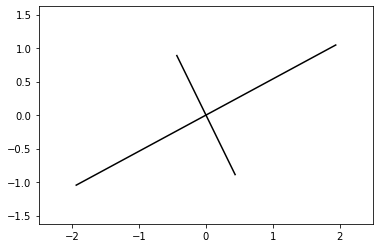

./toyDatasetTrainedModels/20210626-005848/proper_beta0_100_gamma0_005_embgamma0_010/cache_batch_no100000


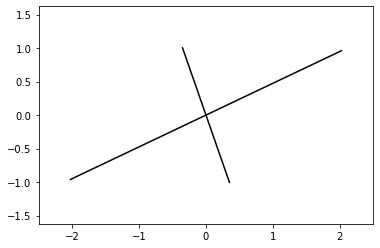

./toyDatasetTrainedModels/20210626-014010/proper_beta0_100_gamma0_005_embgamma0_001/cache_batch_no100000


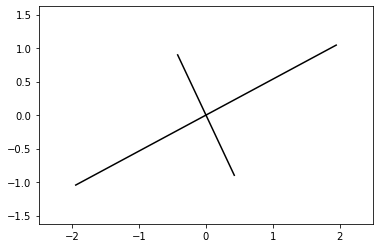

./toyDatasetTrainedModels/20210626-022153/proper_beta0_100_gamma0_005_embgamma0_005/cache_batch_no100000


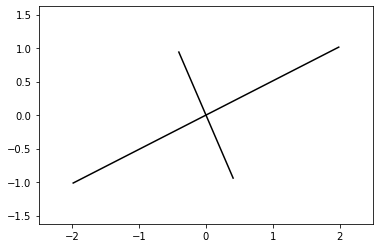

In [9]:
model_path_matches = glob.glob(f"./toyDatasetTrainedModels/*/proper_beta*_gamma*_embgamma*/cache_batch_no100000")
for model_path in model_path_matches:
    print(model_path)
    model = load_model(model_path,device)
    for name, p in model.named_parameters():
        if name == "gen_fcs.0.weight":
            w = p.data.cpu().detach().numpy()
    #print(-np.sort(-np.diag(w.T@w)))
    for v in w.T:
        plt.plot((-v[0],v[0]),(-v[1],v[1]), color="black")
    plt.axis("equal")
    plt.ylim((-2.5,2.5))
    plt.xlim((-2.5,2.5))
    plt.show();plt.close();

./trainedModels/20210622-133654/beta0_001_ica0_000/cache_batch_no100000


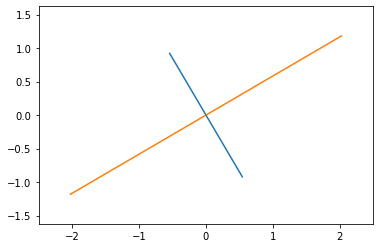

./trainedModels/20210622-135529/beta0_010_ica0_000/cache_batch_no100000


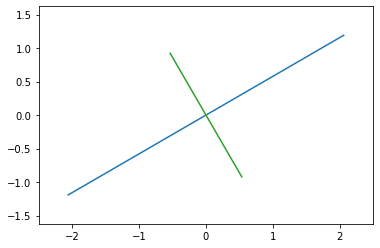

./trainedModels/20210622-140543/beta0_100_ica0_000/cache_batch_no100000


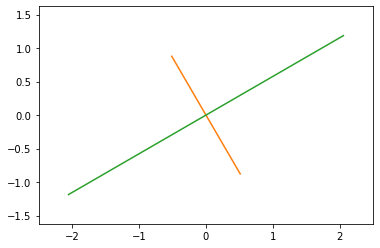

./trainedModels/20210622-141744/beta1_000_ica0_000/cache_batch_no100000


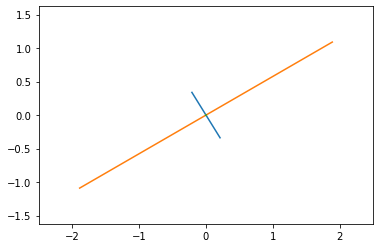

./trainedModels/20210622-142418/beta10_000_ica0_000/cache_batch_no100000


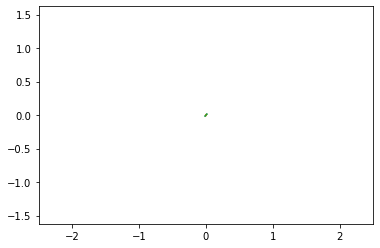

./trainedModels/20210622-144030/beta4_000_ica0_000/cache_batch_no100000


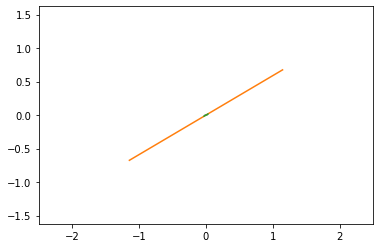

./trainedModels/20210622-163243/beta1_000_ica0_000/cache_batch_no100000


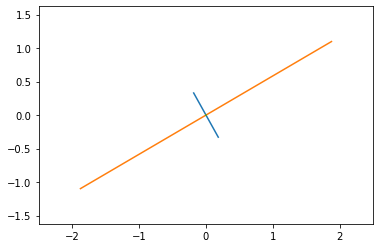

./trainedModels/20210622-164603/beta1_000_ica0_100/cache_batch_no100000


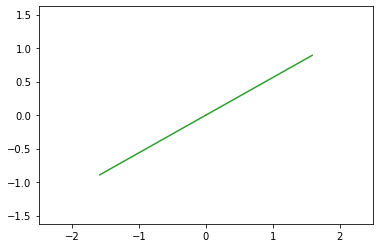

./trainedModels/20210622-170247/beta0_010_ica0_100/cache_batch_no100000


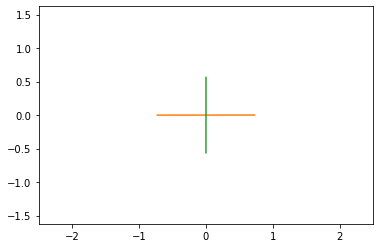

./trainedModels/20210622-173219/beta0_010_ica0_010/cache_batch_no100000


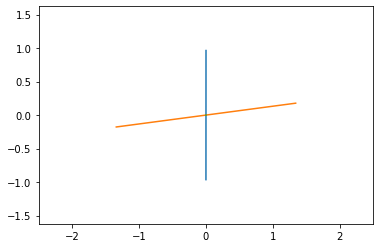

./trainedModels/20210622-173526/beta0_001_ica0_010/cache_batch_no100000


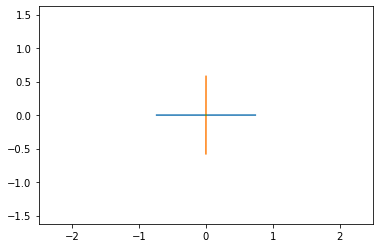

./trainedModels/20210622-174239/beta0_001_ica0_001/cache_batch_no100000


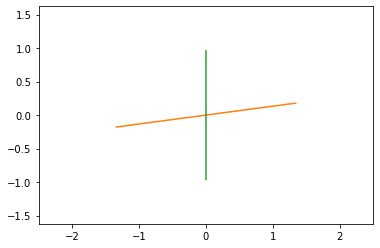

./trainedModels/20210622-174913/beta0_001_ica0_005/cache_batch_no100000


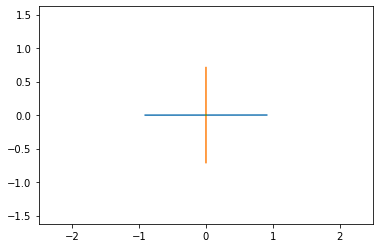

./trainedModels/20210622-175546/beta0_005_ica0_010/cache_batch_no100000


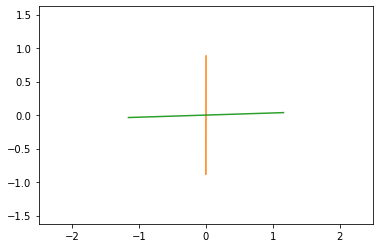

./trainedModels/20210622-180217/beta0_005_ica0_001/cache_batch_no100000


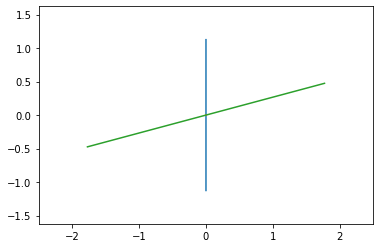

./trainedModels/20210622-180847/beta0_005_ica0_005/cache_batch_no100000


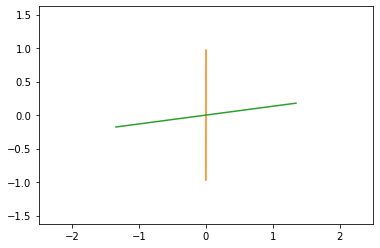

./trainedModels/20210622-181521/beta0_010_ica0_010/cache_batch_no100000


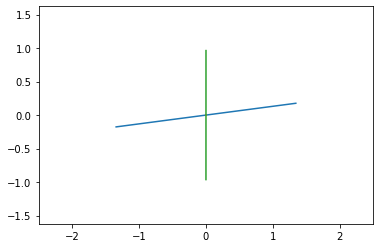

./trainedModels/20210622-182151/beta0_010_ica0_001/cache_batch_no100000


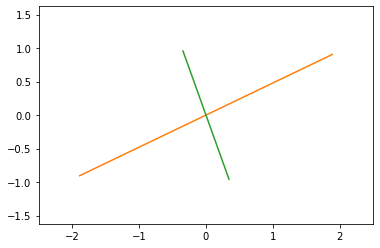

./trainedModels/20210622-182819/beta0_010_ica0_005/cache_batch_no100000


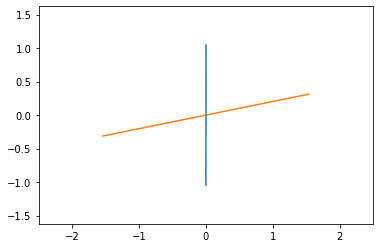

./trainedModels/20210622-183451/beta0_100_ica0_010/cache_batch_no100000


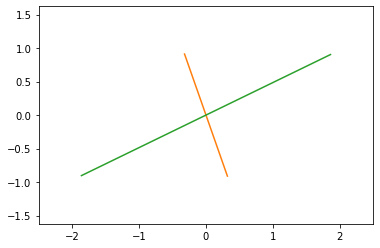

./trainedModels/20210622-184120/beta0_100_ica0_001/cache_batch_no100000


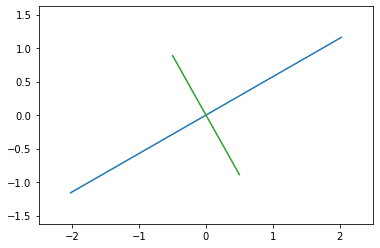

./trainedModels/20210622-184753/beta0_100_ica0_005/cache_batch_no100000


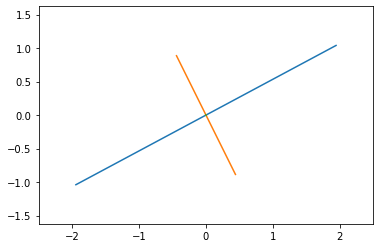

In [10]:
model_path_matches = glob.glob(f"./trainedModels/*/beta*_ica*/cache_batch_no100000")
for model_path in model_path_matches:
    print(model_path)
    model = load_model(model_path,device)
    for name, p in model.named_parameters():
        if name == "gen_fcs.0.weight":
            w = p.data.cpu().detach().numpy()
    #print(-np.sort(-np.diag(w.T@w)))
    for v in w.T:
        plt.plot((-v[0],v[0]),(-v[1],v[1]))
    plt.axis("equal")
    plt.ylim((-2.5,2.5))
    plt.xlim((-2.5,2.5))
    plt.show();plt.close();

### model_path_matches = glob.glob(f"./toyDatasetTrainedModels/*/proper_beta*_gamma*_embgamma*/cache_batch_no100000")
for model_path in model_path_matches:
    print(model_path)
    model = load_model(model_path,device)
    for name, p in model.named_parameters():
        if name == "gen_fcs.0.weight":
            w = p.data.cpu().detach().numpy()
    #print(-np.sort(-np.diag(w.T@w)))
    for v in w.T:
        plt.plot((-v[0],v[0]),(-v[1],v[1]))
    plt.axis("equal")
    plt.ylim((-2.5,2.5))
    plt.xlim((-2.5,2.5))
    plt.show();plt.close();

In [11]:
# note that Jg has shape latent, imageShape...which is transpose
# of what you might expect for a jacobian
# We take the SVD as a way to understand how the jacobian transforms
# the latent space locally
def jacs_svd(Jg, latent_dim = 10):
    np.testing.assert_almost_equal(Jg.shape[0], latent_dim)
    jacobian = Jg.reshape([latent_dim, -1]).transpose()
    u,s,vt = np.linalg.svd(jacobian)
    #print(s, vt)
    return u,s,vt

In [12]:
import scipy.stats

In [13]:
# Following On Implicit Regularization in β-VAEs
# we compute Nabla^2_gz log p(x; g(z))
# = Nabla^2_gz x log g(z) + (1-x)log(1-g(z))
# = - (g(z)^2 - 2g(z)x - x)/(g(z)^2(1-g(z))^2)
# Note: the result is the diagonal of a square matrix with 
# each side length equal to the number of pixels * channels in the image
# ...shaped in a way to make the correspondence to pixels easily interpretable
def Hpx(x, gz):
    #print(min(gz.flatten()), max(gz.flatten()), min(x.flatten()), max(x.flatten()))
    diff = x - gz
    #print(min(diff), max(diff))
    pixelwiseLogprobs = - (gz**2 - 2*gz*x + x)/(gz**2*(1-gz)**2)
    #print(pixelwiseLogprobs.shape)
    return np.clip(pixelwiseLogprobs, -1e32, 0)

# see equation 11 of that paper
# note that Jg has shape latent, imageShape...which is transpose
# of what you might expect for a jacobian
def optLogCovar(x, gz, Jg, beta):
    xshape = x.shape
    gzshape = gz.shape
    Jgshape = Jg.shape
    #print(f"X {xshape}, gz {gzshape}, Jg {Jgshape}")
    np.testing.assert_almost_equal(xshape, gzshape)
    np.testing.assert_almost_equal(xshape, Jgshape[1:])
    H = Hpx(x, gz)
    plt.imshow(H[0]);plt.colorbar();plt.show();plt.close();
    #print(f"H {H.shape}")
    esum = np.einsum("lchw,chw,kchw->lk",Jg, H, Jg)
    #print(esum)
    denominator = np.eye(Jg.shape[0])-(1/beta)*esum
    #print(denominator)
    s = 1/denominator
    return np.log(s)

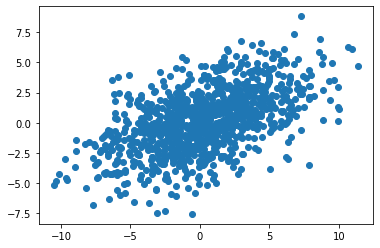

In [14]:
encoding = torch.tensor(np.random.normal(size=(1000,3)).astype(np.float32)*2).cuda()
recon = model.decode(encoding).detach().cpu()
plt.scatter(recon[:,0,0,0],recon[:,1,0,0])

In [15]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
gray = (167/255, 168/255, 170/255, 1)
red = (179/255, 27/255, 27/255, 1)
blue = (0,47/255, 108/255,1)
markersize=10

# Explicitly writing out T

In [16]:
def get_nonzero_eigenvals_vects(w,v):
    orderedInds = np.argsort(-np.abs(w))
    vs = []
    ws = np.zeros((20,20))
    basis_ind = 0
    i = 0
    while i < len(orderedInds):
        indx = orderedInds[i]
        if np.abs(w[indx]) < 0.001:
            break
        if np.max(np.abs(np.imag(v[:,indx]))) < 0.001:
            vs.append(np.real(v[:,indx]))
            ws[basis_ind,basis_ind] = np.real(w[indx])
            basis_ind += 1
            i += 1
        else:
            vs.append(np.real(v[:,indx]))
            vs.append(np.imag(v[:,indx]))
            ws[basis_ind,basis_ind] = np.real(w[indx])
            ws[basis_ind+1,basis_ind+1] = np.real(w[indx])
            ws[basis_ind,basis_ind+1] = np.imag(w[indx])
            ws[basis_ind+1,basis_ind] = -np.imag(w[indx])
            basis_ind += 2
            # complex eigenvalues come in pairs
            i += 2
    ws = ws[:basis_ind, :basis_ind]
    vs = np.array(vs)
    return(ws, vs)

In [17]:
ws, vs = get_nonzero_eigenvals_vects(w,v)
scaling_factor = np.sqrt(np.sum(np.square(vs), axis=1))
scaled_vs = vs/(scaling_factor[:,np.newaxis])
scaled_ws = (scaling_factor[:,np.newaxis]) * ws /scaling_factor[np.newaxis,:]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
f = plt.figure()
plt.imshow(scaled_ws); 
plt.colorbar();
plt.xticks(range(10))
plt.yticks(range(10))
f.savefig("cyclicConsistency/cyclic_consistency_basis_transform.png")
plt.show();plt.close();

In [ ]:
plt.plot(np.sum(np.abs(np.matmul(large_succeptibility, scaled_vs.T) - np.matmul(scaled_vs.T,scaled_ws)),axis=0))

In [ ]:
plt.imshow(test_data[0,0], cmap="gray")

In [ ]:
np.sum(np.square(scaled_vs),axis=1)

In [ ]:
for i in range(10):
    f = plt.figure()
    plt.imshow(scaled_vs[i,:].reshape((64,64)),vmin=-0.1,vmax=0.1);plt.colorbar();plt.show()
    f.savefig(f"cyclicConsistency/cyclic_consistency_basisvect_{i}.png");
    plt.close();

# Other Cycle

In [ ]:
other_recon_ability = np.einsum("labc,jabc->lj",emb_jacs, jacs[:,0,:,:,:])
succeptibility = other_recon_ability
o_w,o_v = np.linalg.eig(succeptibility)

In [ ]:
f = plt.figure(figsize=(10,8))
plt.scatter(np.real(o_w[np.abs(o_w)>0]), np.imag(o_w[np.abs(o_w)>0]))
plt.xlim(-0.25, 1.25)
plt.ylim(-0.7, 0.7)
plt.xlabel("Real")
plt.ylabel("Imag")
plt.axis('equal')
f.savefig("cyclicConsistency/other_cyclic_consistency_eigenvalues.png")
plt.show();

In [ ]:
ws, vs = get_nonzero_eigenvals_vects(o_w,o_v)
scaling_factor = np.sqrt(np.sum(np.square(vs), axis=1))
scaled_vs = vs/(scaling_factor[:,np.newaxis])
scaled_ws = (scaling_factor[:,np.newaxis]) * ws /scaling_factor[np.newaxis,:]

In [ ]:
f = plt.figure()
plt.imshow(scaled_ws); 
plt.colorbar();
plt.xticks(range(10))
plt.yticks(range(10))
f.savefig("cyclicConsistency/other_cyclic_consistency_basis_transform.png")
plt.show();plt.close();

In [ ]:
plt.plot(np.sum(np.abs(np.matmul(succeptibility, scaled_vs.T) - np.matmul(scaled_vs.T,scaled_ws)),axis=0))

In [ ]:
for i in range(10):
    f = plt.figure()
    plt.scatter(range(10), scaled_vs[i,:])
    plt.ylim((-1,1))
    f.savefig(f"cyclicConsistency/other_cyclic_consistency_basisvect_{i}.png");
    plt.show();
    plt.close();

# Scratchwork

In [ ]:
# either switch these timestamps to * (to find any matchign run)
# or update to a particular run. These timestamps are associated with the models used in the paper
for gammastring, timestamp in [("0_1000","*")]:
    print(gammastring)
    print(gammastring)
    print(gammastring)
    print(gammastring)
    model, encoding, logvar, test_data = get_model_and_enc(gammastring,timestamp,test_data)
    recon = model.decode(encoding)
    jacs = vj.compute_generator_jacobian_analytic(model, encoding, device=device,
                                        im_channels=1)#.detach().cpu().numpy()
    jacs_svd(jacs)
    logvar = logvar.detach().cpu().numpy()
    recon = recon.detach().cpu().numpy()
    emb_jacs = vj.compute_embedding_jacobian_analytic(model, torch.tensor(test_data), device=device)
    # everything has a fake "batch" index...
    estLogCovar = optLogCovar(test_data[0], recon[0], jacs[:,0,:,:,:], beta=4)
    print(np.diag(estLogCovar))
    print(logvar)
    u,s,vt = jacs_svd(jacs)
    plt.scatter(range(1,len(s)+1),s);plt.show();plt.close();
    for i in range(10):
        f = plt.figure();
        plt.imshow(u[:,i].reshape((64,64)), vmin=-0.3, vmax=0.3);plt.colorbar();
        f.savefig(f"cyclicConsistency/generative_singular_vector_{i}.png");
        plt.show();plt.close();
    for i in range(10):
        f = plt.figure();
        plt.imshow(jacs[i,0,0], vmin=-2.0, vmax=2.0);plt.colorbar();
        f.savefig(f"cyclicConsistency/generative_jacobian_vector_{i}.png");
        plt.show();plt.close();
        
    gen_delta = np.einsum("lhw,il->ihw",jacs[:,0,0,:,:],scaled_vs).reshape((10,64,64));
    for i in range(10):
        f = plt.figure();
        plt.imshow(gen_delta[i],vmin=-1,vmax=1);
        plt.colorbar();
        f.savefig(f"cyclicConsistency/other_cyclic_half_cycle_{i}.png");
        plt.show();plt.close();

In [ ]:
A = np.random.uniform(size=(600,600))
u, s, vt = np.linalg.svd(A)
evals, evects = np.linalg.eig(A)

In [ ]:
s

In [ ]:
evals

./toyDatasetTrainedModels/20210630-112526/big_lone_beta0_001_gamma0_000_embgamma0_001/cache_batch_no100000


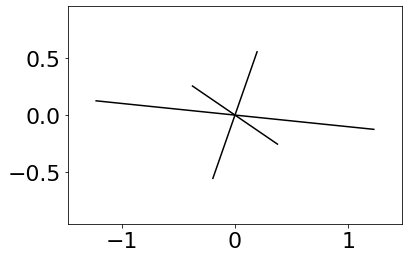

In [23]:
for lossfunc in ["lone", "twoone"]:
    for embgamma in ["0_000","0_001","0_005","0_010","0_100","1_000","10_000"]:
        model_path_matches = glob.glob(f"./toyDatasetTrainedModels/*/big_{lossfunc}_beta*_gamma0_000_embgamma{embgamma}/cache_batch_no100000")
        for model_path in np.sort(model_path_matches):
            print(model_path)
            model = load_model(model_path,device)
            for name, p in model.named_parameters():
                if name == "gen_fcs.0.weight":
                    w = p.data.cpu().detach().numpy()
            #print(-np.sort(-np.diag(w.T@w)))
            for v in w.T:
                plt.plot((-v[0],v[0]),(-v[1],v[1]), color="black")
            plt.axis("equal")
            lim = np.max(np.abs(w))*1.1
            if not lim > 0:
                continue
            plt.ylim((-lim,lim))
            plt.xlim((-lim,lim))
            plt.show();plt.close();